In [82]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import hmmlearn.hmm as hmm
from math import floor
from sklearn.metrics import accuracy_score,roc_auc_score,f1_score,roc_curve,auc
from sklearn.preprocessing import MinMaxScaler,StandardScaler,label_binarize
import os
import glob
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestClassifier
from itertools import product
from pathlib import Path
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [49]:
from model.model_module import get_all_raw_data,create_train_test_data,create_lag_train_test_data\
,model_initialization,forecasting_intialization,blocked_cv,compare_scores,create_results_frame\
,sequence_data_creator,MultivariateLSTMDataset,LSTMClassifier,train_classifier,validate_classifier\
,create_results,compare_lstm_results,plot_ovr_roc

In [2]:
def get_all_raw_data(file_prefix='pipeline/data_files/raw_mags_1m', file_extension="csv"):
    """"
    Takes in the daily financial data and outputs a dataframe of the concatenated dataset of OHCLV data for the entire available period.
    
    file_prefix: filepath and prefix for all raw OHCLV data files
    file_extension: File type for all raw OHCLV data files 
    """
    
    # Define the file prefix and extension 
    file_extension = 'csv'

    # Create the search pattern using a wildcard '*'
    # e.g., 'your_prefix_*.csv'
    pattern = f"{file_prefix}*.{file_extension}" 

    # Get a list of all files matching the pattern
    # You can specify a full directory path if needed, e.g., 'path/to/files/{pattern}'
    file_list = glob.glob(pattern)

    # Initialize an empty list to store individual DataFrames
    dfs = []

    # Loop through the files, read each into a DataFrame, and append to the list
    for filename in file_list:
        df = pd.read_csv(filename)
        dfs.append(df)

    # Concatenate all DataFrames in the list
    # ignore_index=True ensures a continuous index in the final DataFrame, discarding original indices
    combined_df = pd.concat(dfs, ignore_index=True)

    # Display the first few rows of the combined DataFrame
    #print(combined_df.head())
    return combined_df.drop_duplicates()

In [3]:
features=pd.read_csv("pipeline/data_files/features_combined.csv").drop_duplicates()
features['Datetime']=pd.to_datetime(features['Datetime'])

In [4]:
ohclv=get_all_raw_data()
ohclv['Datetime']=pd.to_datetime(ohclv['Datetime'])
ohclv['Datetime']=ohclv.Datetime.apply(lambda x:x.replace(tzinfo=None))-pd.Timedelta(hours=5)

In [5]:
df=ohclv.merge(features,on='Datetime',how='inner')

In [106]:
def create_train_test_data(feature_set_name='pipeline/data_files/features_combined.csv'
                           ,ohclv_name='pipeline/data_files/raw_mags_1m'
                           ,alternative_data=False):
    """
    Creates training and test data from a given feature table and OHCLV data.
    
    feature_set_name: relative filepath and name of the alternative data feature table
    ohclv_name: prefix of all OHCLV data files
    alternative_data: Boolean value indicating whether to include the alternative data in final training and test sets
    
    """
    df=pd.read_csv(feature_set_name)
    df['Datetime']=pd.to_datetime(df['Datetime'])
    ohclv=get_all_raw_data(ohclv_name)
    ohclv['Datetime']=pd.to_datetime(ohclv['Datetime'])
    ohclv['Datetime']=ohclv.Datetime.apply(lambda x:x.replace(tzinfo=None))-pd.Timedelta(hours=5)
    features=ohclv.merge(df,on='Datetime',how='inner')
    ids=features['Datetime']
    if alternative_data:
        X=features.drop(['Datetime','regime_label','pred_vol','hist_vol','vol_ratio'],axis=1)[features.regime_label!='Unknown']
    else:
        X=features[['open','high','low','close','close','volume']][features.regime_label!='Unknown']
    y=features['regime_label'].replace({'Unknown':3,
                                       'Low':0,
                                       'Neutral':1,
                                       'High':2})[features.regime_label!='Unknown']
    train_x,test_x=X[:floor(len(features)*0.7)],X[floor(len(features)*0.7):]
    train_y,test_y=y[:floor(len(features)*0.7)],y[floor(len(features)*0.7):]
    
    return train_x,test_x,train_y,test_y
    

In [6]:
train_x,test_x,train_y,test_y=create_train_test_data(alternative_data=False)
train_x_alt,test_x_alt,train_y,test_y=create_train_test_data(alternative_data=True)

C:\Users\masol\OneDrive\Documents\University of Michigan MADS\SIADS 699 Capstone\Capstone-699-main\model\model_module.py:78: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y=features['regime_label'].replace({'Unknown':3,
C:\Users\masol\OneDrive\Documents\University of Michigan MADS\SIADS 699 Capstone\Capstone-699-main\model\model_module.py:78: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y=features['regime_label'].replace({'Unknown':3,


In [108]:
def model_initialization(train_x=train_x,train_y=train_y):
    """
    Initiliaze parameters for a Hidden Markov Model using a given training set and return a trained model
    
    train_x:dataset/numpy array of predictive features
    train_y: pandas series of numpy array of state labels
    """
    # Number of hidden states (regimes)
    n_components = len(np.unique(train_y))
    n_features = train_x.shape[1]

    # Manually compute the parameters
    startprob = np.zeros(n_components)
    transmat = np.zeros((n_components, n_components))
    means = np.zeros((n_components, n_features))
    covars = np.zeros((n_components, n_features, n_features))
    
    # Loop through each regime to calculate emission parameters (mean and covariance)
    for i in range(n_components):
        regime_data = train_x[train_y == i]
        means[i] = regime_data.mean(axis=0)
        covars[i] = np.cov(regime_data, rowvar=False) + 1e-6 * np.eye(n_features) # Add epsilon for stability
    
    # Calculate transition probabilities from the labeled sequence
    for i in range(len(train_y) - 1):
        transmat[train_y[i], train_y[i+1]] += 1
        
    # Normalize transition matrix
    transmat = transmat / transmat.sum(axis=1, keepdims=True)
    
    # Calculate initial state probabilities (assuming first data point is labeled correctly)
    startprob[train_y[0]] = 1.0

    # Ensure no zero probabilities
    transmat[transmat == 0] = 1e-9
    transmat = transmat / transmat.sum(axis=1, keepdims=True)
    
    # Create a Gaussian HMM model and initialize with computed parameters
    model = hmm.GaussianHMM(n_components=n_components, covariance_type="full", init_params="")
    model.startprob_ = startprob
    model.transmat_ = transmat
    model.means_ = means
    model.covars_ = covars

    print("HMM model initialized successfully with supervised parameters.")
    print("Start probabilities:", model.startprob_)
    print("Transition matrix:", model.transmat_)
    print("Means (Emission parameters):", model.means_)


    return model

In [109]:
def forecasting_intialization(X,y):
    """
    Function to initialize the the hidden markov model for bulk forecasting
    
    X:prediction data
    y:hidden state labels
    """
    X=X.values
    lengths = [len(X)] # For a single time series

    # Initialize a GaussianHMM with the correct number of regimes (hidden states)
    n_regimes = y.nunique()
    model = hmm.GaussianHMM(n_components=n_regimes, n_iter=100)
    regimes=y

    # Manually set the known state sequence to guide training
    # hmmlearn does not have a built-in supervised training method, so we use
    # an iterative approach to find the most likely parameters for the given state sequence.
    # This is an alternative to standard EM for when labels are known.

    # Function to re-estimate parameters based on labeled data
    def fit_supervised_hmm(model, X, regimes):
        for i in range(model.n_iter):
            # E-step with known states
            # The E-step is skipped in favor of a known state sequence

            # M-step: Re-estimate parameters (startprob, transmat, means, covars)
            # We manually re-calculate the necessary statistics based on the known labels

            # Re-estimate start probabilities
            model.startprob_ = np.bincount(regimes[:1], minlength=model.n_components) / len(regimes[:1])

            # Re-estimate transition matrix
            for i in range(model.n_components):
                for j in range(model.n_components):
                    # Count transitions from state i to j
                    transitions = np.sum( (regimes[:-1] == i) & (regimes[1:] == j) )
                    total_transitions = np.sum(regimes[:-1] == i)
                    model.transmat_[i, j] = transitions / total_transitions if total_transitions > 0 else 0

            # Re-estimate means and covariances
            for i in range(model.n_components):
                # Isolate data for the current regime
                regime_data = X[regimes == i]
                if len(regime_data) > 0:
                    model.means_[i, :] = np.mean(regime_data, axis=0)
                    model.covars_[i, :, :] = np.cov(regime_data, rowvar=False) + 1e-6 * np.eye(X.shape[1]) # Add small value for numerical stability

        return model

    # Fit the supervised HMM model
    # Note: For real applications, a custom implementation or a different library might be more robust
    # For demonstration, the manual approach is shown.
    supervised_model = fit_supervised_hmm(model, X, y.values)

    # Evaluate the model (optional, but recommended)
    print("Fitted Model Parameters:")
    print("Start probabilities:\n", supervised_model.startprob_)
    print("Transition matrix:\n", supervised_model.transmat_)
    print("Regime Means:\n", supervised_model.means_)
    print("Regime Covariances:\n", supervised_model.covars_)


    return model

In [11]:
hmm_model =model_initialization(train_x_alt,train_y)

HMM model initialized successfully with supervised parameters.
Start probabilities: [1. 0. 0.]
Transition matrix: [[0.91505935 0.06194362 0.02299703]
 [0.0893887  0.87485582 0.03575548]
 [0.07960742 0.05452563 0.86586696]]
Means (Emission parameters): [[ 6.57187573e+01  6.57420630e+01  6.56937184e+01  6.57176022e+01
   1.07766821e+04  8.96884273e-01  2.72477745e+00  1.14183976e+01
   3.10262088e-01  2.70838034e-01  6.07002080e-03  9.70356478e-01
   8.23110938e-01  7.83073946e-03  3.81690583e+00  3.46003579e+00
   3.18473672e-03  2.44973027e-03  3.78338279e-02  1.39094955e-01
   9.16172107e-01  1.06332531e-02  1.95888971e-02 -1.01401743e-02
   3.70417580e-02  6.91142701e-02 -3.20917159e-02  1.57013261e-01
   4.76829385e-01 -1.13226271e-01 -1.31215311e-01]
 [ 6.54928498e+01  6.55164713e+01  6.54679815e+01  6.54921017e+01
   9.33821165e+03  8.61591696e-01  3.05536332e+00  1.26960784e+01
   2.72388376e-01  2.78428434e-01 -2.14207751e-03  9.41681970e-01
   9.26252776e-01 -3.43640788e-03  4.

In [12]:
# Use the trained HMM to predict the hidden state sequence
# `model.decode()` returns the log-likelihood and the optimal state sequence
log_prob, predicted_regimes = hmm_model.decode(test_x_alt, algorithm="viterbi")
probs=hmm_model.predict_proba(test_x_alt)

In [13]:
accuracy_score(test_y,predicted_regimes)
roc_auc_score(test_y,probs,multi_class='ovr')

0.5304879387865945

# Random Forest

In [84]:
def create_lag_train_test_data(feature_set_name='pipeline/data_files/features_combined.csv'
                           ,ohclv_name='pipeline/data_files/raw_mags_1m.csv'
                           ,alternative_data=False,validation=False):
    """
    Creates training and test data from a given feature table and OHCLV data with 10 minute lag features.
    
    feature_set_name: relative filepath and name of the alternative data feature table
    ohclv_name: prefix of all OHCLV data files
    alternative_data: Boolean value indicating whether to include the alternative data in final training and test sets
    validation: Boolean value of whether or not to include a hold out validation set
    """
    df=pd.read_csv(feature_set_name)
    df['Datetime']=pd.to_datetime(df['Datetime'])
    ohclv=get_all_raw_data()
    ohclv['Datetime']=pd.to_datetime(ohclv['Datetime'])
    ohclv['Datetime']=ohclv.Datetime.apply(lambda x:x.replace(tzinfo=None))-pd.Timedelta(hours=5)
    features=ohclv.merge(df,on='Datetime',how='inner')
    ids=features['Datetime']
    if alternative_data:
        X=features.drop(['Datetime','regime_label','pred_vol','hist_vol','vol_ratio'],axis=1)[features.regime_label!='Unknown']
    else:
        X=features[['open','high','low','close','close','volume']][features.regime_label!='Unknown']
    X=X.shift(10)
    
    scaler=StandardScaler()
    y=features['regime_label'].replace({'Unknown':3,
                                       'Low':0,
                                       'Neutral':1,
                                       'High':2})[features.regime_label!='Unknown']
    X['target_lag']=y.shift(1)
    if validation:
        train_x,val_x,test_x=X[:floor(len(features)*0.7)],X[floor(len(features)*0.7):floor(len(features)*0.85)],X[floor(len(features)*0.85):]
        train_x_scaled=pd.DataFrame(scaler.fit_transform(train_x),columns=train_x.columns)
        val_x_scaled=pd.DataFrame(scaler.transform(val_x),columns=val_x.columns)
        test_x_scaled=pd.DataFrame(scaler.transform(test_x),columns=test_x.columns)
        train_y,val_y,test_y=y[:floor(len(features)*0.7)],y[floor(len(features)*0.7):floor(len(features)*0.85)],y[floor(len(features)*0.85):]
        #train_x_scaled=pd.DataFrame(scaler.fit_transform(train_x),columns=X.columns)
        #test_x_scaled=pd.DataFrame(scaler.transform(test_x),columns=X.columns)
        
        results=train_x_scaled[10:],val_x_scaled[10:],test_x_scaled[10:],train_y[10:],val_y[10:],test_y[10:]
    else:
        train_x,test_x=X[:floor(len(features)*0.7)],X[floor(len(features)*0.7):]
        train_x_scaled=pd.DataFrame(scaler.fit_transform(train_x),columns=train_x.columns)
        test_x_scaled=pd.DataFrame(scaler.transform(test_x),columns=test_x.columns)
        train_y,test_y=y[:floor(len(features)*0.7)],y[floor(len(features)*0.7):]
        #train_x_scaled=pd.DataFrame(scaler.fit_transform(train_x),columns=X.columns)
        #test_x_scaled=pd.DataFrame(scaler.transform(test_x),columns=X.columns)
        results=train_x[10:],test_x[10:],train_y[10:],test_y[10:]
    
    return results

In [14]:
train_x_lag,test_x_lag,train_y_lag,test_y_lag=create_lag_train_test_data(alternative_data=False)
train_x_lag_alt,test_x_lag_alt,train_y_lag_alt,test_y_lag_alt=create_lag_train_test_data(alternative_data=True)

train_x_lstm,val_x_lstm,test_x_lstm,train_y_lstm,val_y_lstm,test_y_lstm=create_lag_train_test_data(alternative_data=False,validation=True)

train_x_lstm_alt,val_x_lstm_alt,test_x_lstm_alt,train_y_lstm_alt,val_y_lstm,test_y_lstm_alt=create_lag_train_test_data(alternative_data=True,validation=True)

C:\Users\masol\OneDrive\Documents\University of Michigan MADS\SIADS 699 Capstone\Capstone-699-main\model\model_module.py:104: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y=features['regime_label'].replace({'Unknown':3,
C:\Users\masol\OneDrive\Documents\University of Michigan MADS\SIADS 699 Capstone\Capstone-699-main\model\model_module.py:104: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y=features['regime_label'].replace({'Unknown':3,
C:\Users\masol\OneDrive\Documents\University of Michigan MADS\SIADS 699 Capstone\Capstone-699-

In [121]:
def blocked_cv(X,y,classifier,param_grid):
    """
    Create a time series split with each test set coming after the training set.
    Perform blocked cross validatoin to do hyperparameter tuning among parameters
    given in dictionary form
    
    X:prediction data numpy array or pandas DataFrame
    y:target variable series
    param_grid: a dictionary with possible hyperparameters to test
    """
    # Initialize TimeSeriesSplit
    # n_splits determines the number of splits (folds)
    # gap allows for a gap between the training and testing sets
    # max_train_size can limit the maximum size of the training set
    results=[]
    best_score = -np.inf
    result_grid={}
    tscv = TimeSeriesSplit(n_splits=5)
    param_combinations=list(product(*param_grid.values()))
    param_keys = list(param_grid.keys())
    for comb in param_combinations:
        current_params = dict(zip(param_keys, comb))
        model=RandomForestClassifier(random_state=24,**current_params)
        
        fold_score=[]
        # Iterate through the splits
        for train_index, test_index in tscv.split(X):
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]
            model.fit(X_train,y_train)
            probs=model.predict_proba(X_test)
            fold_score.append(roc_auc_score(y_test,probs,multi_class='ovr'))
        avg_score=np.mean(fold_score)
        std_score=np.std(fold_score)
        results.append({'params': current_params, 'avg_score': avg_score,'std_score':std_score})
        
        if avg_score > best_score:
            best_score = avg_score
            best_params = current_params
    #for res in results:
    #    key={res['params']}
    #    score={res['avg_score']}
    #    result_grid[key]=score
        
    return results

In [39]:
param_grid={
'n_estimators':[10],#89 alt 164
'max_depth':[10],#9 alt 25
'max_features':range(1,31)#12 alt 10
}
blocked_cv(train_x_lag,train_y_lag,classifier=RandomForestClassifier(random_state=24),param_grid=param_grid)

[{'params': {'n_estimators': 10, 'max_depth': 10, 'max_features': 1},
  'avg_score': 0.8705381358013767,
  'std_score': 0.03786445336053744},
 {'params': {'n_estimators': 10, 'max_depth': 10, 'max_features': 2},
  'avg_score': 0.8651685511966443,
  'std_score': 0.08121679546187653},
 {'params': {'n_estimators': 10, 'max_depth': 10, 'max_features': 3},
  'avg_score': 0.8903638930447808,
  'std_score': 0.0353619982158973},
 {'params': {'n_estimators': 10, 'max_depth': 10, 'max_features': 4},
  'avg_score': 0.8914594122754466,
  'std_score': 0.035034559392944385},
 {'params': {'n_estimators': 10, 'max_depth': 10, 'max_features': 5},
  'avg_score': 0.878682535421236,
  'std_score': 0.060566835860630844},
 {'params': {'n_estimators': 10, 'max_depth': 10, 'max_features': 6},
  'avg_score': 0.887909806302754,
  'std_score': 0.04309458502021715},
 {'params': {'n_estimators': 10, 'max_depth': 10, 'max_features': 7},
  'avg_score': 0.8798323560456065,
  'std_score': 0.05822227724452374},
 {'para

In [162]:
def plot_ovr_roc(test_y,probs,n_classes=3,name='Normal Data',model_type='Random Forest'):
    """
    Plot a One vs Rest ROC Curv with labeled AUC value
    
    test_y:True labels
    probs: Predicted class probabilities
    n_classes: number of classes
    name: Name indicated normal or alternative data
    model_type: Type of model
    """
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    test_y_bin=label_binarize(test_y, classes=np.arange(n_classes))
    
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(test_y_bin[:, i], probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # 7. Plot the ROC curves for each class
    plt.figure(figsize=(8, 6))
    colors = ['blue', 'red', 'green', 'purple'] # Define colors for each class
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label=f'ROC curve of class {i} (AUC = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier') # Diagonal line for random classifier
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic (ROC) Curve - One-vs-Rest:{name}')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.savefig(f"model/model_graphs/ROC_Curve_{model_type}_{name}.png")


In [163]:
def compare_scores(train_x,train_y,test_x,test_y,
                  train_x_alt,test_x_alt):
    """
    Function to compare with roc-auc scores of a random forest classifier fitted with and without alternative data
    train_x:train data without alternative data
    train_y:train labels
    test_x: test data without alternative labels
    train_x_alt: train data with alternative data
    test_x_alt: test data with alternative data
    """

    rf_alt=RandomForestClassifier(random_state=42,n_estimators=172,max_depth=2,max_features=10)
    rf=RandomForestClassifier(random_state=42,n_estimators=64,max_depth=9,max_features=10)
        
    rf.fit(train_x,train_y)
    rf_alt.fit(train_x_alt,train_y)
    probs_train=rf.predict_proba(train_x)
    probs=rf.predict_proba(test_x)
    probs_alt_train=rf_alt.predict_proba(train_x_alt)
    probs_alt=rf_alt.predict_proba(test_x_alt)
    score=roc_auc_score(test_y,probs,multi_class='ovr')
    score_alt=roc_auc_score(test_y,probs_alt,multi_class='ovr')
    
    n_classes=train_y.nunique()
    plot_ovr_roc(test_y,probs,name='Normal Data')
    plot_ovr_roc(test_y,probs_alt,name='Alternative Data')

    
    
    
    probs_frame_1=pd.DataFrame(probs_train,columns=['probability_low','probability_medium','probability_high'])
    probs_frame_2=pd.DataFrame(probs,columns=['probability_low','probability_medium','probability_high'])
    probs_frame_1['set']='train'
    probs_frame_2['set']='test'
    
    alt_frame_1=pd.DataFrame(probs_alt_train,columns=['probability_low_with_alt','probability_medium_with_alt','probability_high_with_alt'])
    alt_frame_2=pd.DataFrame(probs_alt,columns=['probability_low_with_alt','probability_medium_with_alt','probability_high_with_alt']) 
    alt_frame_1['set']='train'
    alt_frame_2['set']='test'
    
    
    
    return score_alt,score,pd.concat([alt_frame_1,alt_frame_2]),pd.concat([probs_frame_1,probs_frame_2])
    

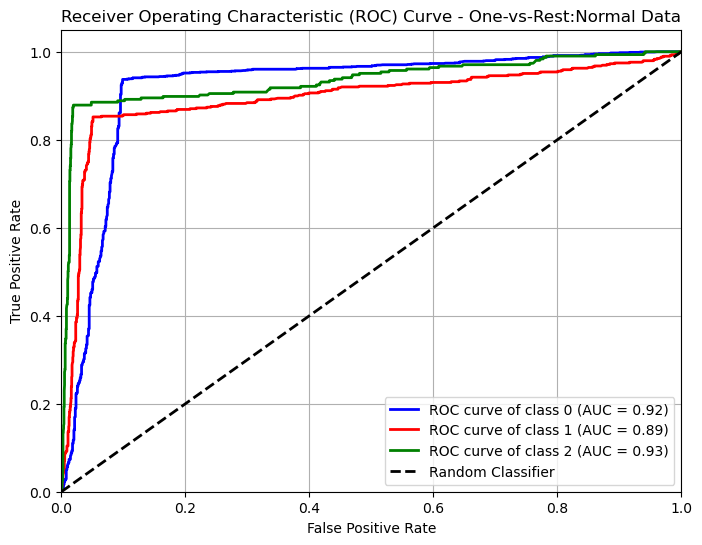

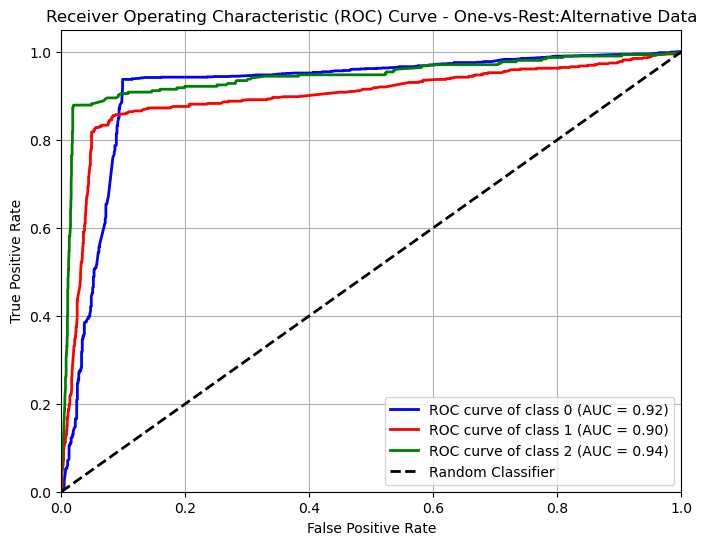

In [15]:
score_alt,score_norm,probs_alt,probs=\
compare_scores(train_x_lag,train_y_lag,test_x_lag,test_y_lag,train_x_lag_alt,test_x_lag_alt)

In [16]:
score_alt,score_norm

(0.9179438401999583, 0.9159186466003391)

In [125]:
def create_results_frame(features,probs_alt,probs,output_path='model/data_files/results.csv'):
    """
    Create a final dataframe with labels and probabilties across the entire time series
    features: features dataframe
    probs_alt: dataframe of probabilities generated by model with alternative data
    probs:dataframe of probabilites generated by model without alternative data
    """
    labels=pd.concat([features[10:floor(len(features)*0.7)],features[floor(len(features)*0.7):][10:]])[['Datetime','regime_label']]
    labels=labels[labels.regime_label!='Unknown']
    
    results=pd.concat([labels.reset_index(drop=True),probs.reset_index(drop=True),probs_alt.reset_index(drop=True)],axis=1)\
    .dropna(subset='Datetime')
    
    results.to_csv(output_path)
    
    return results

In [17]:
create_results_frame(features,probs_alt,probs)

,Datetime,regime_label,probability_low,probability_medium,probability_high,set,probability_low_with_alt,probability_medium_with_alt,probability_high_with_alt,set
0,2025-11-04 09:40:00,Low,0.978942,0.016509,0.004549,train,0.704602,0.197100,0.098298,train
1,2025-11-04 09:41:00,Low,0.972114,0.022423,0.005463,train,0.711961,0.192631,0.095409,train
2,2025-11-04 09:42:00,Low,0.977561,0.018272,0.004166,train,0.709541,0.194187,0.096272,train
3,2025-11-04 09:43:00,Low,0.892329,0.102508,0.005163,train,0.729113,0.184069,0.086818,train
4,2025-11-04 09:44:00,Low,0.952332,0.041265,0.006403,train,0.729113,0.184069,0.086818,train
...,...,...,...,...,...,...,...,...,...,...
7545,2025-12-02 15:47:00,Neutral,0.047730,0.923744,0.028526,test,0.267465,0.503212,0.229323,test
7546,2025-12-02 15:48:00,High,0.049313,0.925211,0.025476,test,0.267465,0.503212,0.229323,test
7547,2025-12-02 15:49:00,High,0.084717,0.876320,0.038962,test,0.267465,0.503212,0.229323,test
7548,2025-12-02 15:50:00,High,0.045188,0.930194,0.024617,test,0.267487,0.502618,0.229894,test


# LSTM

In [165]:
def sequence_data_creator(sequence_length=10,feature_set_name='pipeline/data_files/features_combined.csv'
                           ,ohclv_name='pipeline/data_files/raw_mags_1m'
                           ,alternative_data=False):
    """
    Converts a dataframe of structured multivariate time series data to a dataloader containing sequences
    
    sequence_length:The number of consecutive timestamps to compute a sequence
    feature_set_name: the path of the file containing the feature set
    ohclv_name: the path of the 
    """
    df=pd.read_csv(feature_set_name)
    df['Datetime']=pd.to_datetime(df['Datetime'])
    ohclv=get_all_raw_data(ohclv_name)
    ohclv['Datetime']=pd.to_datetime(ohclv['Datetime'])
    ohclv['Datetime']=ohclv.Datetime.apply(lambda x:x.replace(tzinfo=None))-pd.Timedelta(hours=5)
    features=ohclv.merge(df,on='Datetime',how='inner')
    ids=features['Datetime']
    if alternative_data:
        X=features.drop(['Datetime','regime_label','pred_vol','hist_vol','vol_ratio'],axis=1)[features.regime_label!='Unknown']
    else:
        X=features[['open','high','low','close','close','volume']][features.regime_label!='Unknown']
    y=features['regime_label'].replace({'Unknown':3,
                                       'Low':0,
                                       'Neutral':1,
                                       'High':2})[features.regime_label!='Unknown']
    scaler=StandardScaler()
    X=scaler.fit_transform(X)
    num_features = X.shape[1]
    
    # Create sequences
    # Using a simple sliding window to create sequences
    sequences = []
    labels = [] # Assuming you have a label for each sequence
    for i in range(len(X) - sequence_length):
        sequences.append(X[i : i + sequence_length])
        # Assuming the label corresponds to the last element in the sequence
        labels.append(y[i + sequence_length - 1])
        
    sequences = np.array(sequences)
    labels = np.array(labels)

    # Convert to PyTorch tensors
    X = torch.tensor(sequences, dtype=torch.float32)
    y = torch.tensor(labels, dtype=torch.long) # Use long for classification labels


    class StructuredDataset(Dataset):
        def __init__(self, X, y):
            self.X = X
            self.y = y

        def __len__(self):
            return len(self.X)

        def __getitem__(self, idx):
            return self.X[idx], self.y[idx]

    dataset = StructuredDataset(X, y)
    dataloader = DataLoader(dataset, batch_size=32, shuffle=True)
    
    return dataloader
    
    

In [168]:
class MultivariateLSTMDataset(Dataset):
    def __init__(self, data, sequence_length, target_column):
        self.sequence_length = sequence_length
        self.X, self.y = self.create_sequences(data, target_column)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return torch.tensor(self.X[idx], dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.long) # Use torch.long for classification targets

    def create_sequences(self, data, target_column):
        X, y = [], []
        # Exclude the target column from features
        features = data.values
        targets = target_column.values

        for i in range(len(data) - self.sequence_length + 1):
            # Get the input sequence of features
            seq_x = features[i:(i + self.sequence_length)]
            X.append(seq_x)
            # Get the target label (e.g., at the end of the sequence) for classification
            # For classification, the label is usually a single value for the entire sequence
            seq_y = targets[i + self.sequence_length - 1]
            y.append(seq_y)
        return np.array(X), np.array(y)




In [18]:
SEQUENCE_LENGTH = 10
BATCH_SIZE = 32
# Create Dataset instances
train_dataset = MultivariateLSTMDataset(train_x_lstm, SEQUENCE_LENGTH, train_y_lstm)
val_dataset = MultivariateLSTMDataset(val_x_lstm, SEQUENCE_LENGTH, val_y_lstm)
test_dataset = MultivariateLSTMDataset(test_x_lstm, SEQUENCE_LENGTH, test_y_lstm)

# Create DataLoader instances
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False) # Shuffle can be True for train data in classification if temporal order across batches isn't critical
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Create Dataset instances
train_dataset_alt = MultivariateLSTMDataset(train_x_lstm_alt, SEQUENCE_LENGTH, train_y_lstm)
val_dataset_alt = MultivariateLSTMDataset(val_x_lstm_alt, SEQUENCE_LENGTH, val_y_lstm)
test_dataset_alt = MultivariateLSTMDataset(test_x_lstm_alt, SEQUENCE_LENGTH, test_y_lstm)

# Create DataLoader instances
train_loader_alt = DataLoader(train_dataset_alt, batch_size=BATCH_SIZE, shuffle=False) # Shuffle can be True for train data in classification if temporal order across batches isn't critical
val_loader_alt = DataLoader(val_dataset_alt, batch_size=BATCH_SIZE, shuffle=False)
test_loader_alt = DataLoader(test_dataset_alt, batch_size=BATCH_SIZE, shuffle=False)

In [21]:
class LSTMClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(LSTMClassifier, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        # Initialize hidden and cell states
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))

        # Take the output from the last time step for classification
        out = self.fc(out[:, -1, :])
        return out
    
def train_classifier(model,train_loader=train_loader,num_epochs=1,criterion=nn.CrossEntropyLoss()): 
    """
    Function to train a pytorch RNN
    model: Pytorch classifier
    train_loader:Pytorch dataloader
    num_epochs: Number of training cycles to compute
    criterion: metric with with to compute loss function
    
    """
    optimizer=optim.Adam(model.parameters())
    for epoch in range(num_epochs):
        epochLoss = []
        for batch_idx, (data, labels) in enumerate(train_loader):
            optimizer.zero_grad()
            predictions = model(data)
            loss = criterion(predictions, labels)
            loss.backward()
            optimizer.step()
            epochLoss.append(loss.item())

    
    



In [118]:
def validate_classifier(model, val_loader, criterion):
    """
    Function to validate the performance of a pytorch RNN for hyperparameter tuning
    model: Pytorch classifier
    val_loader:Pytorch dataloader
    criterion: metric with with to compute loss function
    
    """
    model.eval() # Set the model to evaluation mode
    with torch.no_grad(): # Disable gradient calculation for validation
        total_loss = 0
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
        avg_loss = total_loss / len(val_loader)
    return avg_loss

In [22]:
#Train model with no alternative data
input_size=train_loader.dataset[0][0].shape[1]
batch_size=32
hidden_size=64
num_layers=2
num_classes=3
num_epochs=50

model =LSTMClassifier(input_size, hidden_size, num_layers, num_classes)
criterion=nn.CrossEntropyLoss()
optimizer=optim.Adam(model.parameters())

for epoch in range(num_epochs):
    train_classifier(model, train_loader, 1,criterion) # Train for one epoch
    validate_classifier(model, val_loader, criterion)

In [23]:
#Train model with alternative data
input_size=train_loader_alt.dataset[0][0].shape[1]
batch_size=32
hidden_size=128
num_layers=4
num_classes=3
num_epochs=20

model_alt =LSTMClassifier(input_size, hidden_size, num_layers, num_classes)
criterion=nn.CrossEntropyLoss()
optimizer=optim.Adam(model_alt.parameters())

for epoch in range(num_epochs):
    train_classifier(model_alt, train_loader_alt, 1,criterion) # Train for one epoch
    validate_classifier(model_alt, val_loader_alt, criterion)

In [61]:
def create_results(dataloader,model):
    """Takes in a dataloader and trained LSTM model and outputs a numpy array of class probabilities
        
        dataloader: Pytorch dataloader of prediction data and results
        model: trained pytorch RNN
    """
    all_data_tensors = []
    labels=[]
    for data,label in dataloader:
        all_data_tensors.append(data)
        labels.append(label)
        data_tensor = torch.cat(all_data_tensors, dim=0)
        label_tensor=torch.cat(labels,dim=0)
    probabilities=torch.softmax(model(data_tensor),dim=1)
    
    return probabilities.detach().numpy(),label_tensor.numpy()


In [47]:
create_results(test_loader,model)

2

In [78]:
def compare_lstm_results(test_loader,model,test_loader_alt,model_alt):
    """
    Function to compare test results with and without the alternative data
    
    test_loader:dataloader containing test data
    model:trained RNN model
    test_loader_alt dataloader containing test data with alternative data
    model_alt: RNN model trained with alternative data
    
    """
    probabilities,labels=create_results(test_loader,model)
    probabilities_alt,_=create_results(test_loader_alt,model_alt)
    

    plot_ovr_roc(labels,probabilities,name='Normal Data',model_type='LSTM')
    plot_ovr_roc(labels,probabilities_alt,name='Alternative Data',model_type='LSTM')
    print("ROC AUC with normal data (LSTM):",roc_auc_score(labels,probabilities,multi_class='ovr'))
    print("ROC AUC with alternative data (LSTM):",roc_auc_score(labels,probabilities_alt,multi_class='ovr'))

ROC AUC with normal data (LSTM): 0.9578879095274453
ROC AUC with alternative data (LSTM): 0.9262944210500885


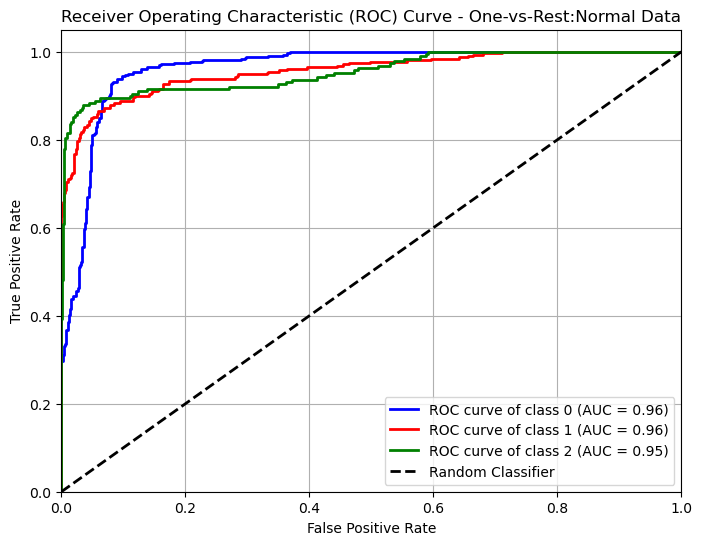

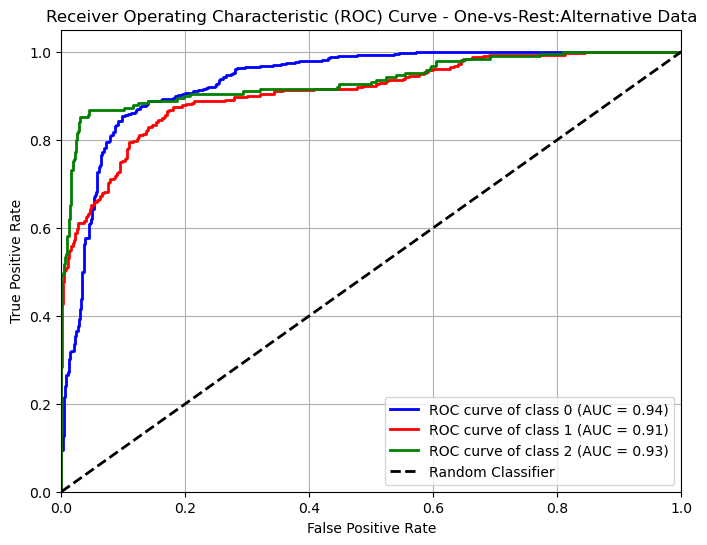

In [79]:
compare_lstm_results(test_loader,model,test_loader_alt,model_alt)